In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load data and basic visualization
df_boston_calendar = pd.read_csv('./data/airbnb_boston/calendar.csv')
df_boston_listings = pd.read_csv('./data/airbnb_boston/listings.csv')
df_boston_reviews = pd.read_csv('./data/airbnb_boston/reviews.csv')
df_seattle_calendar = pd.read_csv('./data/airbnb_seattle/calendar.csv')
df_seattle_listings = pd.read_csv('./data/airbnb_seattle/listings.csv')
df_seattle_reviews = pd.read_csv('./data/airbnb_seattle/reviews.csv')

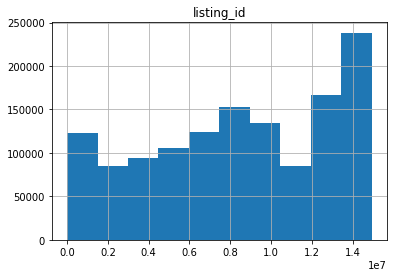

In [2]:
# The above are variables that python is treating as numeric variables, and therefore, we 
# could send them into our linear model blindly to predict the response
# Let's take a quick look at our data first

df_boston_calendar.hist();

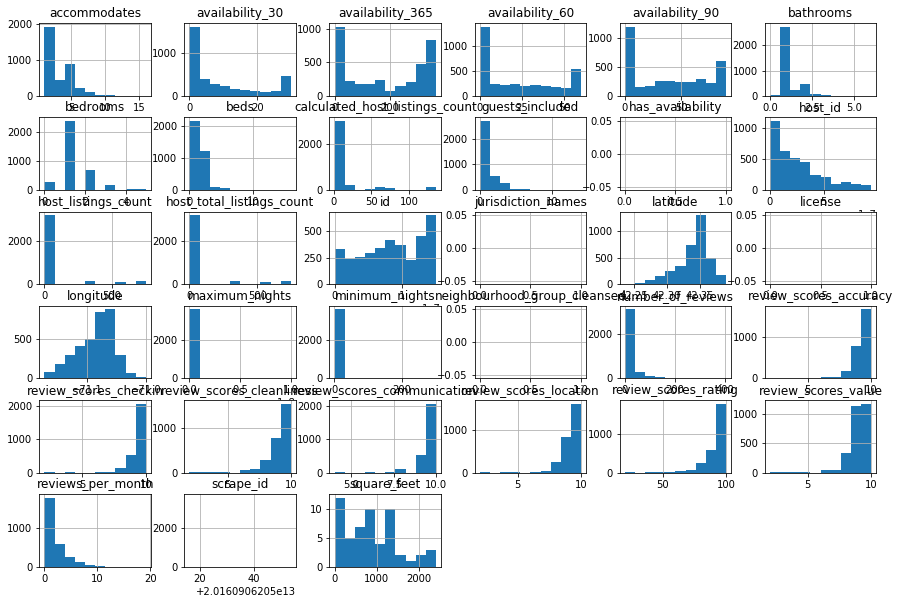

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
df_boston_listings.hist();

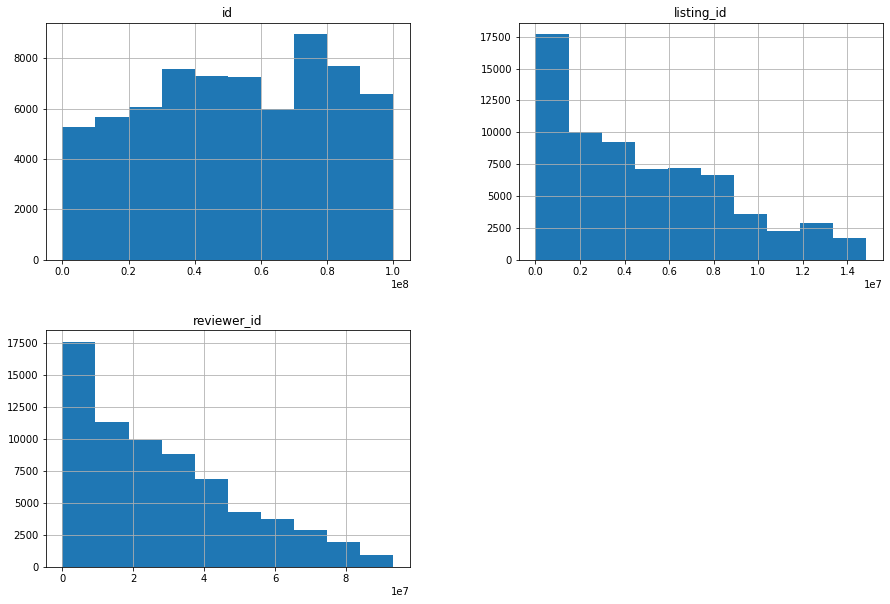

In [4]:
df_boston_reviews.hist();

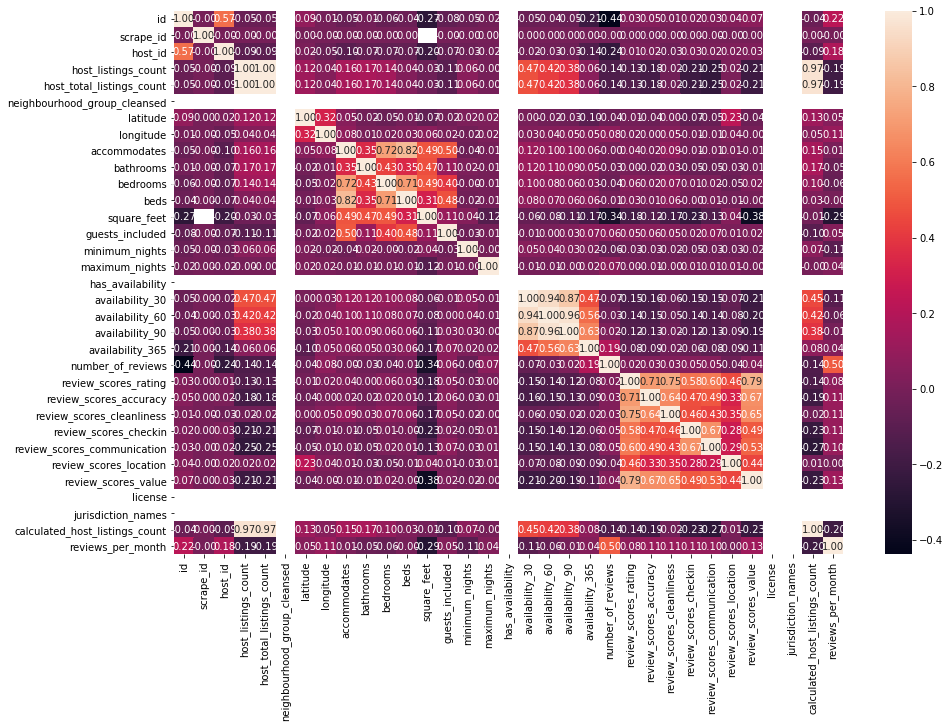

In [5]:
sns.heatmap(df_boston_listings.corr(), annot=True, fmt=".2f");

In [6]:
# all field reguarding "neighborhood"
df_boston_listings.filter(regex='neighb')
df_boston_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [18]:
df_boston_listings[['price', 'weekly_price', 'monthly_price', 'security_deposit']]

,price,weekly_price,monthly_price,security_deposit
0,$250.00,NaN,NaN,NaN
1,$65.00,$400.00,NaN,$95.00
2,$65.00,$395.00,"$1,350.00",NaN
3,$75.00,NaN,NaN,$100.00
4,$79.00,NaN,NaN,NaN
...,...,...,...,...
3580,$69.00,NaN,NaN,$95.00
3581,$150.00,NaN,NaN,$100.00
3582,$198.00,NaN,NaN,NaN
3583,$65.00,NaN,NaN,$100.00


In [22]:
# find the buiest week of the year
df_boston_calendar

,listing_id,date,available,price
0,12147973,2017-09-05,0,NaN
1,12147973,2017-09-04,0,NaN
2,12147973,2017-09-03,0,NaN
3,12147973,2017-09-02,0,NaN
4,12147973,2017-09-01,0,NaN
...,...,...,...,...
1308885,14504422,2016-09-10,0,NaN
1308886,14504422,2016-09-09,0,NaN
1308887,14504422,2016-09-08,0,NaN
1308888,14504422,2016-09-07,0,NaN


In [27]:
# find the buiest week of the year
# data preparation: 
# - convert price from str $XX to float XX
# - convert available t/f str to boolean                     
#df_boston_calendar.dropna(inplace=True)  # remove nan
df_boston_calendar['price'] = df_boston_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
df_boston_calendar['available'].replace('t', 1, inplace=True)
df_boston_calendar['available'].replace('f', 0, inplace=True)
df_boston_calendar.head()

,listing_id,date,available,price
0,12147973,2017-09-05,0,NaN
1,12147973,2017-09-04,0,NaN
2,12147973,2017-09-03,0,NaN
3,12147973,2017-09-02,0,NaN
4,12147973,2017-09-01,0,NaN


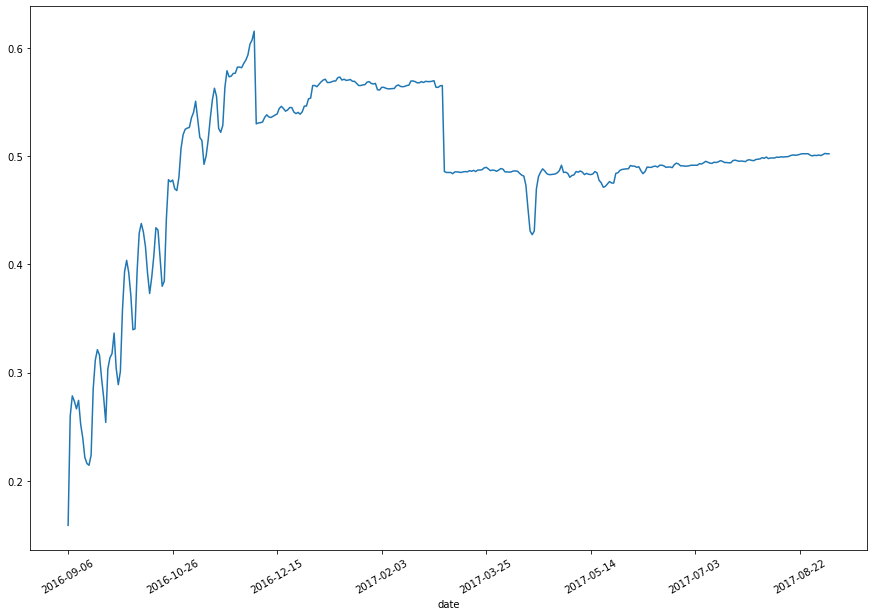

In [25]:
grouby_date = df_boston_calendar.groupby(['date'])
num_listing_over_time = grouby_date['listing_id'].count()
aviability_over_time = grouby_date['available'].sum()
(aviability_over_time / num_listing_over_time).plot(rot=30);

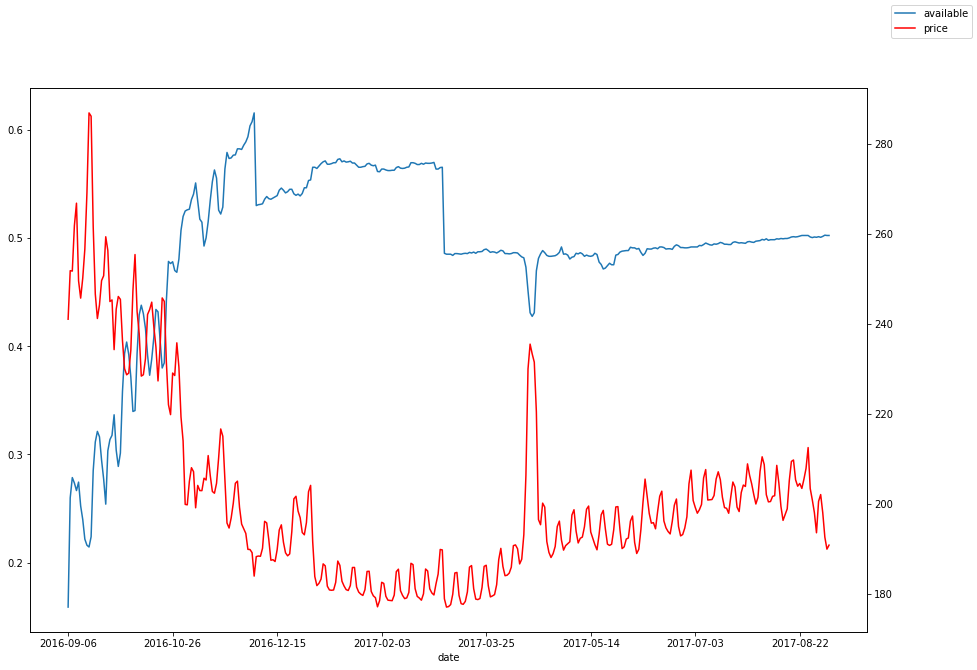

In [35]:
# avg weekly availability
mean_availability = grouby_date.mean()['available']
#mean_availability.plot();
all_plot = grouby_date.mean()[['available', 'price']]
ax = all_plot.plot(y="available", legend=False)
ax2 = ax.twinx()
all_plot.plot(y="price", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

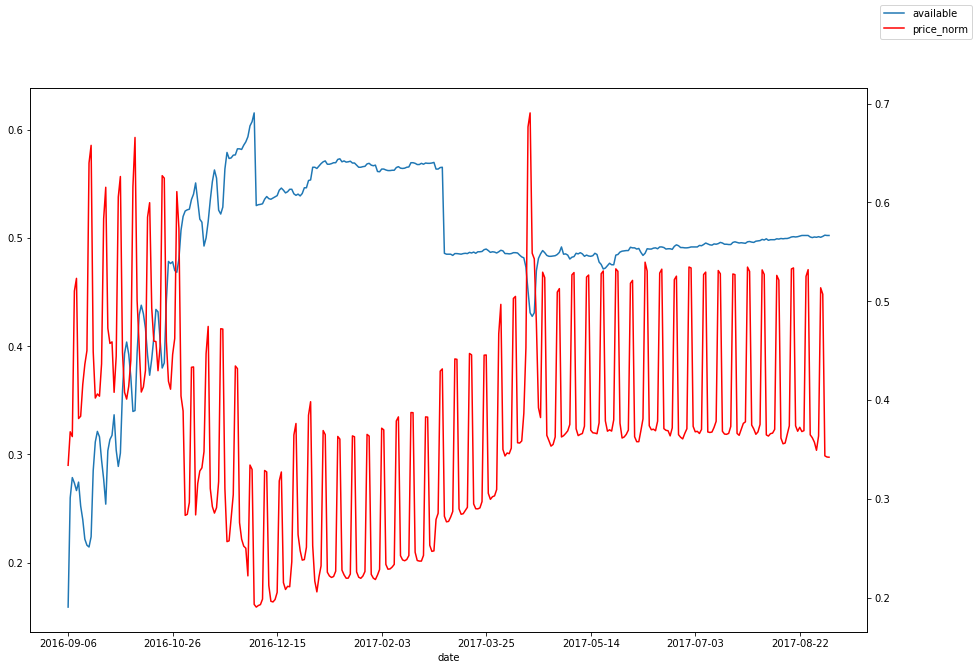

In [70]:
# in order to aggregate the price data, for each listing perform a min-max normalization to get 
# equal range over the prices
agg_listings = df_boston_calendar.groupby('listing_id')
min_max_prices = pd.DataFrame()
min_max_prices['min'] = agg_listings.min()['price']
min_max_prices['max'] = agg_listings.max()['price']
df_boston_calendar_normed = df_boston_calendar.copy()
for listing_id in min_max_prices.index:
    listing_price_norm = df_boston_calendar_normed[df_boston_calendar_normed['listing_id'] == listing_id]['price']
    listing_price_norm -= min_max_prices.loc[listing_id]['min']
    listing_price_norm /= (min_max_prices.loc[listing_id]['max'] - min_max_prices.loc[listing_id]['min'])
    df_boston_calendar_normed.loc[df_boston_calendar_normed['listing_id'] == listing_id, 'price_norm'] = listing_price_norm

grouby_date = df_boston_calendar_normed.groupby(['date'])
all_plot = grouby_date.mean()[['available', 'price_norm']]
ax = all_plot.plot(y="available", legend=False)
ax2 = ax.twinx()
all_plot.plot(y="price_norm", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [75]:
df_boston_calendar['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [83]:
df_boston_calendar_normed.groupby(['listing_id']).mean()['price'].describe([0.33, 0.66])

count    2906.000000
mean      196.935127
std       157.729807
min        11.000000
33%       110.000000
50%       160.000000
66%       219.458711
max      4000.000000
Name: price, dtype: float64

In [115]:
cat1 = [0, 110]
cat2 = [110, 220]
cat3 = [220, 4000]
groupby_mean_price = df_boston_calendar_normed.groupby(['listing_id']).mean()['price']
cat1_listings = groupby_mean_price[groupby_mean_price <= 110].index
cat2_listings = groupby_mean_price[(groupby_mean_price > 110) & (groupby_mean_price <= 220)].index
cat3_listings = groupby_mean_price[groupby_mean_price > 220].index
print(f"Cat 1 listings: {len(cat1_listings)}")
print(f"Cat 2 listings: {len(cat2_listings)}")
print(f"Cat 3 listings: {len(cat3_listings)}")
print(f"Overall listings: {len(groupby_mean_price)}")
print(f"Listings with missin price: {groupby_mean_price.isna().sum()}")
df_cat1 = df_boston_calendar_normed[df_boston_calendar_normed['listing_id'].isin(cat1_listings)]
df_cat2 = df_boston_calendar_normed[df_boston_calendar_normed['listing_id'].isin(cat2_listings)]
df_cat3 = df_boston_calendar_normed[df_boston_calendar_normed['listing_id'].isin(cat3_listings)]

Cat 1 listings: 973
Cat 2 listings: 956
Cat 3 listings: 977
Overall listings: 3585
Listings with missin price: 679


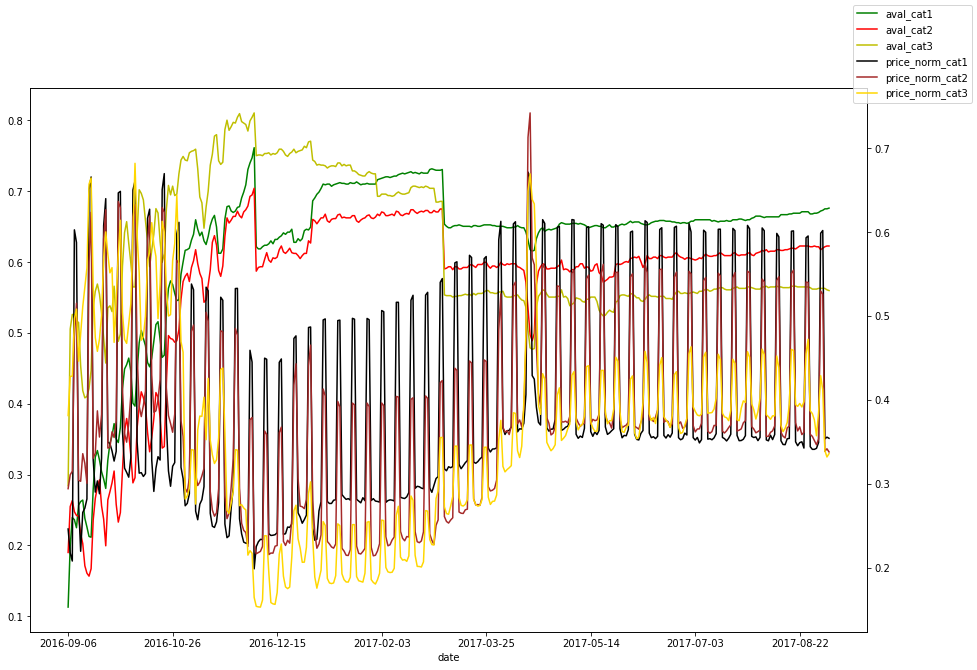

In [140]:
grouby_date_cat1 = df_cat1.groupby(['date'])
grouby_date_cat2 = df_cat2.groupby(['date'])
grouby_date_cat3 = df_cat3.groupby(['date'])
df_plot_cat1 = grouby_date_cat1.mean()[['available', 'price_norm']]
df_plot_cat2 = grouby_date_cat2.mean()[['available', 'price_norm']]
df_plot_cat3 = grouby_date_cat3.mean()[['available', 'price_norm']]
ax = df_plot_cat1.plot(y="available", legend=False, color='g', label='aval_cat1')
df_plot_cat2.plot(y="available", ax=ax, legend=False, color='r', label='aval_cat2')
df_plot_cat3.plot(y="available", ax=ax, legend=False, color='y', label='aval_cat3')
ax2 = ax.twinx()
df_plot_cat1.plot(y="price_norm", ax=ax2, legend=False, color='black', label='price_norm_cat1')
df_plot_cat2.plot(y="price_norm", ax=ax2, legend=False, color='brown', label='price_norm_cat2')
df_plot_cat3.plot(y="price_norm", ax=ax2, legend=False, color='gold', label='price_norm_cat3')
ax.figure.legend()
plt.show()

In [172]:
# absolute price max for each cats
print(f"Cat 1 maxs: {df_plot_cat1.nlargest(n=3, columns='price_norm')}")
print(f"Cat 2 maxs: {df_plot_cat2.nlargest(n=3, columns='price_norm')}")
print(f"Cat 3 maxs: {df_plot_cat3.nlargest(n=3, columns='price_norm')}")

Cat 1 maxs:             available  price_norm
date                             
2017-04-14   0.631038    0.671569
2016-10-22   0.468654    0.669746
2016-09-17   0.211716    0.665748
Cat 2 maxs:             available  price_norm
date                             
2017-04-15   0.497388    0.742137
2017-04-14   0.533960    0.712906
2016-09-30   0.233020    0.636454
Cat 3 maxs:             available  price_norm
date                             
2016-10-08   0.564995    0.682022
2017-04-15   0.479017    0.669445
2016-09-17   0.447288    0.664573


In [170]:
# spike size
print(f"Cat 1 mins: {df_plot_cat1.nsmallest(n=3, columns='price_norm')}")
print(f"Cat 2 mins: {df_plot_cat2.nsmallest(n=3, columns='price_norm')}")
print(f"Cat 3 mins: {df_plot_cat3.nsmallest(n=3, columns='price_norm')}")

Cat 1 maxs:             available  price_norm
date                             
2016-12-04   0.761562    0.198472
2016-09-08   0.239466    0.207790
2016-09-07   0.199383    0.217262
Cat 2 maxs:             available  price_norm
date                             
2017-01-30   0.661442    0.214012
2017-01-18   0.662487    0.214399
2017-01-31   0.663532    0.214637
Cat 3 maxs:             available  price_norm
date                             
2016-12-07   0.751279    0.152857
2016-12-06   0.751279    0.153106
2016-12-05   0.750256    0.153761


In [182]:
# find minimum at least 1 week before 2017-04-14
# spike size
cat_1_min = df_plot_cat1["2017-04-08":"2017-04-15"].nsmallest(n=1, columns='price_norm')['price_norm']
print(f"Cat 1 min in previous week: {cat_1_min.values}")
cat_2_min = df_plot_cat2["2017-04-08":"2017-04-15"].nsmallest(n=1, columns='price_norm')['price_norm']
print(f"Cat 2 min in previous week: {cat_2_min.values}")
cat_3_min = df_plot_cat3["2017-04-08":"2017-04-15"].nsmallest(n=1, columns='price_norm')['price_norm']
print(f"Cat 3 min in previous week: {cat_3_min.values}")

Cat 1 min in previous week: [0.36182397]
Cat 2 min in previous week: [0.36782873]
Cat 3 min in previous week: [0.33116044]


In [166]:
# boston: any new listing?
grouby_date_count = df_boston_calendar.groupby('date').count()['listing_id']
print(f"Listings number (min/max/avg): {grouby_date_count.min()}/{grouby_date_count.max()}/{grouby_date_count.mean()}")

Listings number (min/max/avg): 3586/3586/3586.0


In [183]:
# now compare 3 cats to gte main difference in some field like:  
df_boston_listings_fixed.head()

#comp_df = pd.merge(ed_1_perc, ed_0_perc, left_index=True, right_index=True)
#comp_df.columns = ['ed_1_perc', 'ed_0_perc']
#comp_df['Diff_HigherEd_Vals'] = comp_df['ed_1_perc'] - comp_df['ed_0_perc']
#comp_df.style.bar(subset=['Diff_HigherEd_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,"(Other pet(s),)","(Washer / Dryer,)","(Smoking Allowed,)","(Suitable for Events,)","(Wheelchair Accessible,)","(Elevator in Building,)","(Pool,)","(Doorman,)","(Paid Parking Off Premises,)","(Free Parking on Street,)"
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,0,0,0,0,0,0,0,0,0,0
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,0,0,0,0,0,0,0,0,0,0
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,0,0,0,0,0,0,0,0,0,0
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,0,0,0,0,0,0,0,0,0,0
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,0,0,0,0,0,0,0,0,0,0


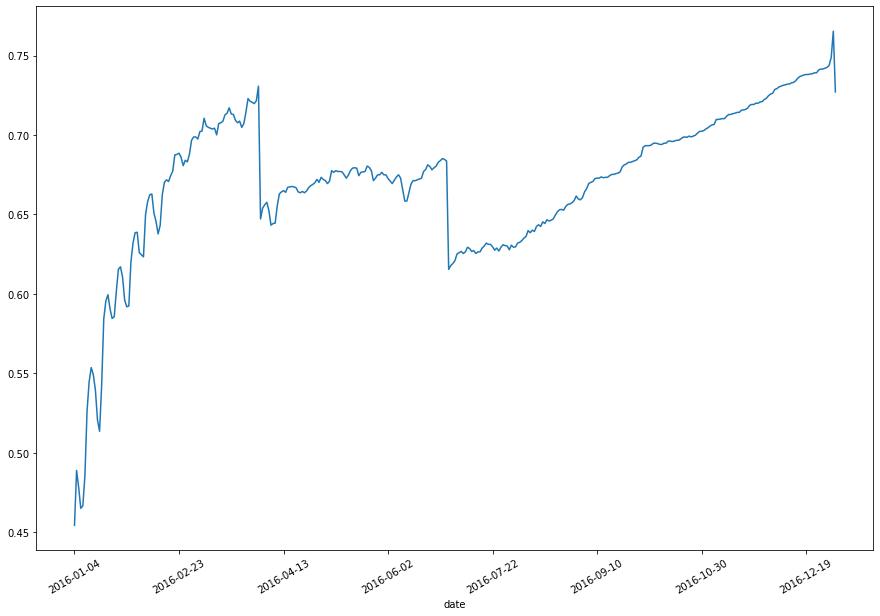

In [57]:
#df_boston_calendar.dropna(inplace=True)  # remove nan
df_seattle_calendar['price'] = df_seattle_calendar['price'].replace('[\$,]', '', regex=True).astype(float)
df_seattle_calendar['available'].replace('t', 1, inplace=True)
df_seattle_calendar['available'].replace('f', 0, inplace=True)
df_seattle_calendar.head()

grouby_date = df_seattle_calendar.groupby(['date'])
num_listing_over_time = grouby_date['listing_id'].count()
aviability_over_time = grouby_date['available'].sum()
(aviability_over_time / num_listing_over_time).plot(rot=30);

In [10]:
num_listing_over_time.describe()

count     365.0
mean     3818.0
std         0.0
min      3818.0
25%      3818.0
50%      3818.0
75%      3818.0
max      3818.0
Name: listing_id, dtype: float64

In [11]:
# cosa è successo a fine dicembre 2016 e inizio luglio 2017 in US?

In [12]:
df_seattle_listings['neighborhood_overview'].coun

AttributeError: 'Series' object has no attribute 'coun'

In [13]:
df_seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [14]:
df_boston_listings[['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee']]

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee
0,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00
1,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00
2,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,$65.00,$395.00,"$1,350.00",NaN,NaN
3,House,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$75.00,NaN,NaN,$100.00,$50.00
4,House,Private room,2,1.5,1.0,2.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,$79.00,NaN,NaN,NaN,$15.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,Apartment,Private room,3,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,$69.00,NaN,NaN,$95.00,NaN
3581,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$150.00,NaN,NaN,$100.00,$15.00
3582,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{""translation missing: en.hosting_amenity_49"",...",NaN,$198.00,NaN,NaN,NaN,NaN
3583,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",NaN,$65.00,NaN,NaN,$100.00,NaN


In [15]:
list_vars = df_boston_listings['amenities'].iloc[0].split(",")
list_vars[0] = list_vars[0][1:]
list_vars[-1] = list_vars[-1][:-1]
list_vars[1].replace('"', "")

'Wireless Internet'

In [216]:
# need to create a dedicate colums to use it
# at first get a list of all possible variables

def convert_pseudo_json_to_list(pseudo_json):
    
    list_vars = pseudo_json.split(",")
    list_vars[0] = list_vars[0][1:]
    list_vars[-1] = list_vars[-1][:-1]
    
    for i in range(len(list_vars)):
        list_vars[i] = list_vars[i].replace('"', "")  # fix '"example"' to 'example'
    
    # remove erroneous values
    if "translation missing: en.hosting_amenity_49" in list_vars:
        list_vars.remove("translation missing: en.hosting_amenity_49")
    if "translation missing: en.hosting_amenity_50" in list_vars:
        list_vars.remove("translation missing: en.hosting_amenity_50")
    if "" in list_vars:
        list_vars.remove("")
    
    return list_vars

def get_unique_variables_in_amenities(col):
    
    available_variables = list()
    
    for value in col:
        list_vars = convert_pseudo_json_to_list(value)
    
        for each in list_vars:
            if each not in available_variables:
                available_variables.append(each)
    
    return available_variables

#available_amenities = get_unique_variables_in_amenities(df_boston_listings['amenities'])
#print(available_amenities[0])
#a = pd.DataFrame(index=df_boston_listings.index, columns=available_amenities).fillna(0)
#print(a.columns)


def convert_amenities_column_to_multiple_quantitative_columns(col):
    
    available_amenities = get_unique_variables_in_amenities(col)
    
    output_df = pd.DataFrame(index=col.index, columns=available_amenities).fillna(0)
    
    for index in output_df.index:
        list_vars = convert_pseudo_json_to_list(col.loc[index])
        
        output_df.loc[index, list_vars] = 1
        #print(list_vars)
    
    return output_df
    


amenities_continuous_df = convert_amenities_column_to_multiple_quantitative_columns(df_boston_listings['amenities'])
df_boston_listings_fixed = df_boston_listings.drop(columns='amenities')
df_boston_listings_fixed = df_boston_listings_fixed.join(amenities_continuous_df)
df_boston_listings_fixed.head()
amenities_continuous_df.head()

,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,Washer,Dryer,...,Other pet(s),Washer / Dryer,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [217]:
amenities_continuous_df_join = amenities_continuous_df.join(df_boston_listings_fixed['id'])
amenities_continuous_df_join.head()

,TV,Wireless Internet,Kitchen,Free Parking on Premises,Pets live on this property,Dog(s),Heating,Family/Kid Friendly,Washer,Dryer,...,Washer / Dryer,Smoking Allowed,Suitable for Events,Wheelchair Accessible,Elevator in Building,Pool,Doorman,Paid Parking Off Premises,Free Parking on Street,id
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,12147973
1,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,3075044
2,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,6976
3,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,1436513
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,7651065


In [247]:
cat_1_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat1_listings)].mean()
cat_2_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat2_listings)].mean()
cat_3_perc_amenities = amenities_continuous_df_join[amenities_continuous_df_join['id'].isin(cat3_listings)].mean()
cat_1_perc_amenities.drop(index='id', inplace=True)
cat_2_perc_amenities.drop(index='id', inplace=True)
cat_3_perc_amenities.drop(index='id', inplace=True)


cat_1_perc_amenities.rename('cat_1_perc', inplace=True)
cat_2_perc_amenities.rename('cat_2_perc', inplace=True)
cat_3_perc_amenities.rename('cat_3_perc', inplace=True)

comp_df = pd.merge(cat_1_perc_amenities, cat_2_perc_amenities, left_index=True, right_index=True)
comp_df = pd.merge(comp_df, cat_3_perc_amenities, left_index=True, right_index=True)
comp_df['Diff_Vals_1vs2'] = comp_df['cat_2_perc'] - comp_df['cat_1_perc']
comp_df['Diff_Vals_2vs3'] = comp_df['cat_3_perc'] - comp_df['cat_2_perc']
comp_df['Diff_Vals_1vs3'] = comp_df['cat_3_perc'] - comp_df['cat_1_perc']
comp_df.sort_values(by=['Diff_Vals_1vs3', 'Diff_Vals_2vs3', 'Diff_Vals_1vs2'], ascending=False, inplace=True)
comp_df.style.bar(subset=['Diff_Vals_1vs2', 'Diff_Vals_2vs3', 'Diff_Vals_1vs3'], align='mid', color=['#d65f5f', '#5fba7d'])
#comp_df.style.bar(subset=['Diff_Vals_1vs2', 'Diff_Vals_2vs3'], align='mid', color=['#d65f5f', '#5fba7d'])

,cat_1_perc,cat_2_perc,cat_3_perc,Diff_Vals_1vs2,Diff_Vals_2vs3,Diff_Vals_1vs3
Cable TV,0.273381,0.518828,0.743091,0.245447,0.224263,0.469710
TV,0.492292,0.805439,0.933470,0.313147,0.128030,0.441178
Family/Kid Friendly,0.368962,0.503138,0.784033,0.134176,0.280895,0.415071
Elevator in Building,0.070915,0.161088,0.470829,0.090173,0.309741,0.399914
Air Conditioning,0.624872,0.876569,0.938588,0.251698,0.062018,0.313716
Gym,0.028777,0.064854,0.329580,0.036077,0.264727,0.300803
24-Hour Check-in,0.244604,0.369247,0.505629,0.124643,0.136383,0.261025
Internet,0.620761,0.720711,0.853634,0.099951,0.132922,0.232873
Dryer,0.604317,0.620293,0.830092,0.015976,0.209799,0.225776
Washer,0.609455,0.617155,0.830092,0.007700,0.212937,0.220637
